In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

from scipy.stats import norm

In [3]:
class HedgeNet(nn.Module):
    
    def __init__(self, nNodes, nLayers ):
        super(HedgeNet, self).__init__()
        
        # single hidden layer
        self.prop_in_to_h = nn.Linear( 2, nNodes)
        
        self.prop_h_to_h = []
        for i in range(nLayers-1):
            self.prop_h_to_h.append(nn.Linear(nNodes, nNodes))
            
        self.prop_h_to_out = nn.Linear(nNodes, 1)

    def forward(self, x):
        
        # input into  hidden layer
        h = torch.sigmoid(self.prop_in_to_h(x))
        
        for prop in self.prop_h_to_h:
            h = torch.relu(prop(h))
        
        # hidden layer to output layer - no activation
        y = self.prop_h_to_out(h)
        
        return y
    
    def parameters(self):
        
        params = list(self.prop_in_to_h.parameters())
        for prop in self.prop_h_to_h:
            params += list(prop.parameters())
            
        params += list(self.prop_h_to_out.parameters())
        
        return params

In [4]:
# simulation engine for the environment

# option contract parameters
T = 1
K = 10

# market environment parameters
sigma = 0.2
r = 0.02
mu = 0.05
S0 = 10

# trading parameters
NdT = 50
t = np.linspace(0,T,NdT)
dt = t[1]-t[0]       

In [5]:
def CallPrice(S,K,tau,sigma,r):
    dp = (np.log(S/K)+(r+0.5*sigma**2)*tau)/(np.sqrt(tau)*sigma)
    dm = (np.log(S/K)+(r-0.5*sigma**2)*tau)/(np.sqrt(tau)*sigma)
    
    return S*norm.cdf(dp) - K*np.exp(-r*tau)*norm.cdf(dm) 

C0 = CallPrice(S0, K, T, sigma, r)
print(C0)

0.8916037278572535


In [6]:
def CallDelta(S,K,tau,sigma,r):
    tau+=1e-10
    dp = (np.log(S/K)+(r+0.5*sigma**2)*tau)/(np.sqrt(tau)*sigma)
    
    return norm.cdf(dp)

delta = CallDelta(S0, K, T, sigma, r)
print(delta)

0.5792597094430134


In [11]:
def RunHedge(S, alpha):
    
    # start the bank account with value of contract and purchasing initial shares
    bank = C0 - alpha[:,0,0]*S[:,0]
    
    for i in range(NdT-1):
        
        # accumulate bank account to next time step
        bank *= np.exp(r*dt)
        
        # rebalance the position
        bank -= (alpha[:,i+1,0]-alpha[:,i,0]) * S[:,i+1]
        
    # liquidate terminal assets, and pay what you owe from the contract
    bank += alpha[:,-1,0]*S[:,-1] - (S[:,-1]-K)*(S[:,-1]>K)    
    
    return bank

def Sim(net, nsims):
    
    S = torch.zeros((nsims, NdT))
    
    # simulate the asset price
    S[:,0] = S0
    for i in range(NdT-1):
        S[:,i+1] = S[:,i] * torch.exp( (mu-0.5*sigma**2)*dt + np.sqrt(dt)*sigma* torch.normal(0,1,size=(nsims,)) )
    
    print("S",S)
    
    # combine the features into a tensor of dimension nsims x ndt x 2 
    x = torch.zeros((nsims, NdT,2))
    x[:,:,0] = torch.tensor(2*t/T-1).float().repeat(nsims,1)
    x[:,:,1] = 2*S/S0-1
    
    print("x",x)
    
    # push the x values through the ANN -- the last dimension is treated as the features
    alpha = net(x)
    
    print("alpha",alpha)
    
    bank = RunHedge(S, alpha)
    print("bank",bank)
    
    # run the Black-Scholes hedge for comparison
    
    alpha_BS = torch.unsqueeze( torch.tensor(CallDelta(S.detach().numpy(), K, T-np.matlib.repmat(t,nsims,1), sigma, r)), dim=2)
    print("alpha_BS",alpha_BS)
    
    bank_BS = RunHedge(S, alpha_BS)
    print("bank_BS",bank_BS)
    
    return bank, bank_BS
        


In [12]:
net = HedgeNet(50,3)
print(net)
for param in net.parameters():
    print(type(param.data), param.size())

HedgeNet(
  (prop_in_to_h): Linear(in_features=2, out_features=50, bias=True)
  (prop_h_to_out): Linear(in_features=50, out_features=1, bias=True)
)
<class 'torch.Tensor'> torch.Size([50, 2])
<class 'torch.Tensor'> torch.Size([50])
<class 'torch.Tensor'> torch.Size([50, 50])
<class 'torch.Tensor'> torch.Size([50])
<class 'torch.Tensor'> torch.Size([50, 50])
<class 'torch.Tensor'> torch.Size([50])
<class 'torch.Tensor'> torch.Size([1, 50])
<class 'torch.Tensor'> torch.Size([1])


In [13]:
Sim(net, 3)

S tensor([[10.0000,  9.7788,  9.8996,  9.4146,  9.2377,  8.6487,  9.0081,  9.1288,
          8.8715,  9.4227,  9.0304,  8.6092,  8.3342,  8.4353,  8.5426,  9.0384,
          9.0563,  8.9389,  8.9839,  9.2597,  9.5992,  9.5890,  9.3664,  9.0003,
          8.7233,  8.8362,  8.4911,  8.6940,  8.6937,  8.4568,  8.4273,  8.3405,
          8.6753,  9.4076,  9.5814,  9.3492,  9.3687,  9.4474,  9.4380,  9.1939,
          9.4278,  9.4373,  9.6090,  9.4603,  9.0801,  9.3653,  9.5980,  9.5385,
          9.3315,  9.0649],
        [10.0000,  9.8064,  9.9295,  9.9252,  9.8698,  9.5798,  9.2345,  9.1925,
          8.9891,  8.7905,  8.9689,  9.0555,  8.8126,  8.8380,  8.1903,  8.2461,
          8.2987,  8.0305,  8.1348,  7.8471,  7.8128,  7.7993,  7.7509,  7.9200,
          8.0151,  7.8672,  7.7523,  8.1218,  8.2729,  8.1670,  8.0098,  8.1331,
          8.1915,  8.0785,  8.0624,  7.8286,  7.6304,  7.4125,  7.7159,  7.6521,
          7.3157,  7.0693,  7.2051,  7.0641,  6.8696,  6.7927,  7.0185,  7.2244

(tensor([0.7310, 0.3941, 0.5365], grad_fn=<AddBackward0>),
 tensor([-0.0247,  0.0461, -0.0477], dtype=torch.float64))

In [9]:
def Plot_Strategy(net, name=""):
    
    t = [0,0.5*T,0.9*T]
    S = np.linspace(0.75*K,1.25*K,51)
    plt.figure(figsize=(10,4))
    for i, t_ in enumerate(t):
        
        plt.subplot(1,3,i+1)
        plt.title('t=' + str(t_),fontsize=16)
        
        plt.plot(S, CallDelta(S,K, T-t_, sigma, r))
        
        x = torch.zeros((len(S),2))
        x[:,0] = 2*t_/T-1
        x[:,1] = torch.tensor(2*S/S0-1)
        
        alpha = net(x)
        
        plt.plot(S, alpha.detach().numpy(),'--')
        
        plt.xlabel('S', fontsize=16)
        plt.ylabel(r'$\Delta(S)$', fontsize=16)
        plt.ylim(0,1)
    
    plt.tight_layout()
    
    if not name == "":
        plt.savefig(name, dpi=300)
        
    plt.show()


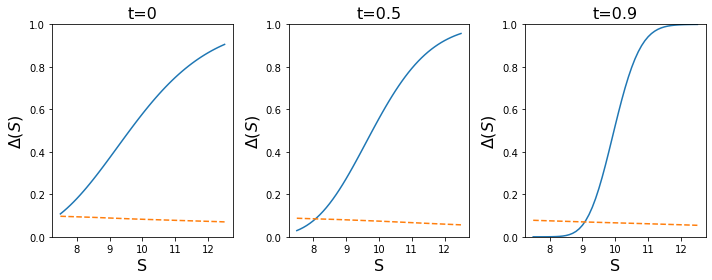

In [10]:
Plot_Strategy(net)

In [11]:
def Plot_PnL(loss_hist, net, name=""):
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.plot(loss_hist)
    plt.yscale('log')
    plt.xlabel('iteration',fontsize=16)
    plt.ylabel('loss',fontsize=16)
    plt.ylim(1e-3,1)

    plt.subplot(1,2,2)
    PnL, PnL_BS = Sim(net, 5_000)
    plt.hist(PnL_BS.detach().numpy(), bins=np.linspace(-1,1,51), alpha=0.5, label="BS")
    plt.hist(PnL.detach().numpy(), bins=np.linspace(-1,1,51),alpha=0.5, label="ANN")    
    plt.xlabel('P&L',fontsize=16)
    plt.ylabel('Freq.',fontsize=16)
    plt.ylim(0,1000)
    plt.legend()
    
    plt.tight_layout(pad=2)
    
    if not name == "":
        plt.savefig(name, dpi=300)
        
    plt.show()  

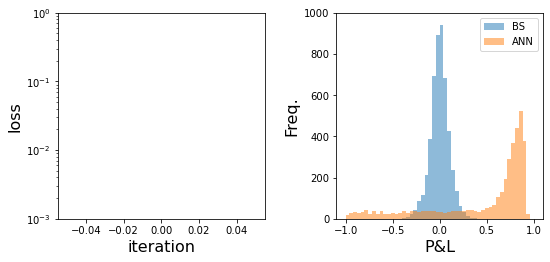

In [12]:
Plot_PnL([], net)

In [13]:
def FitNet(net, name=""):
    
    mini_batch_size = 100
    

    # create  optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.005)

    Nepochs = 5_000
    loss_hist = []
    
    if not name == "":
        Plot_PnL(loss_hist, net, name + "_dist_0")
        Plot_Strategy(net, name + "_strat_0")
    else:
        Plot_PnL(loss_hist, net)
        Plot_Strategy(net)
    
#     torch.autograd.set_detect_anomaly(True)

    for epoch in range(Nepochs):  # loop over the dataset multiple times


        # grab a mini-batch from simulations
        PnL, PnL_BS = Sim(net, mini_batch_size)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # compute the loss associated with this output
        loss = torch.mean(PnL**2)

        # propogate the sensitivity of the output to the model parameters 
        # backwards through the computational graph
        loss.backward()

        # update the weights and biases by taking a SGD step
        optimizer.step()

        # store running loss
        loss_hist.append(  loss.item() )

        # plot output every 200 iterations
        if( ( (epoch) % 200 == 0) and (epoch>10) ):
            print(epoch)
            if not name == "":
                Plot_PnL(loss_hist, net, name + "_dist" + str(int(epoch/200)).zfill(2) )
                Plot_Strategy(net, name + "_strat_" + str(int(epoch/200)).zfill(2) )
            else:
                Plot_PnL(loss_hist, net)
                Plot_Strategy(net)




    print(epoch)
    Plot_PnL(loss_hist, net)
    Plot_Strategy(net)

    print('Finished Training')
    
    return loss_hist

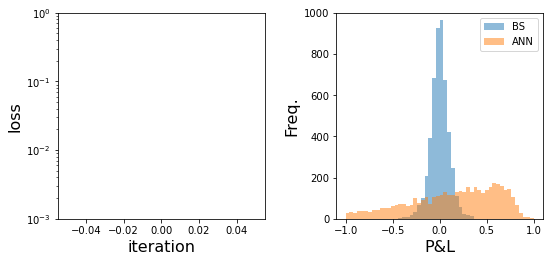

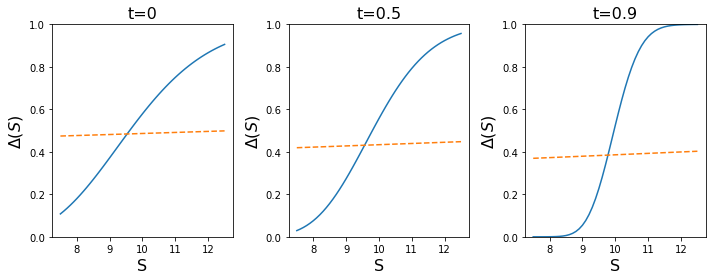

200


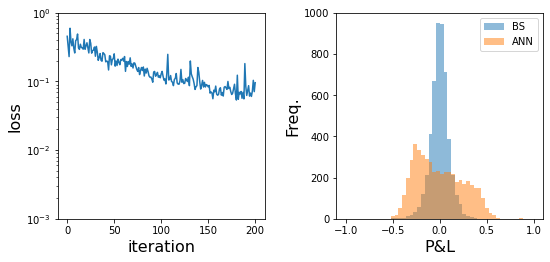

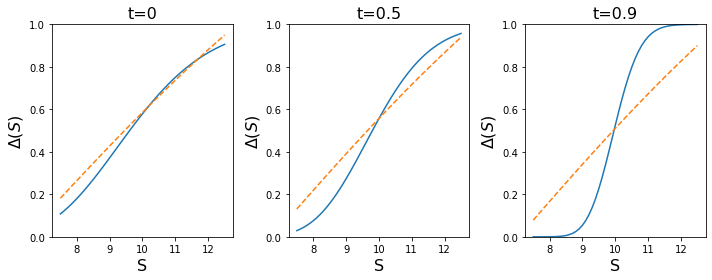

400


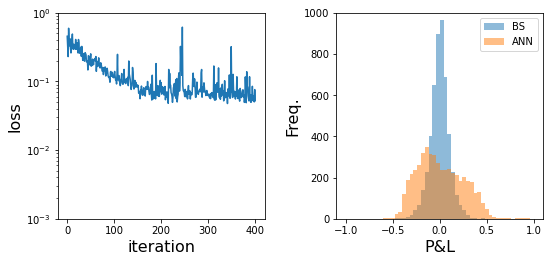

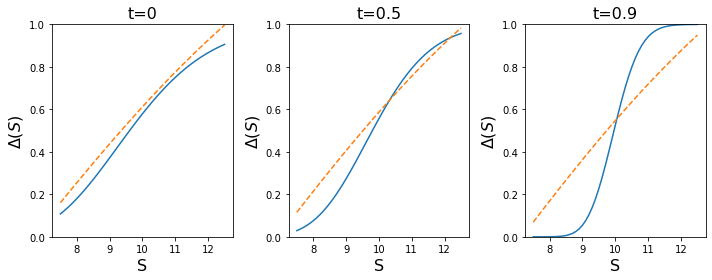

600


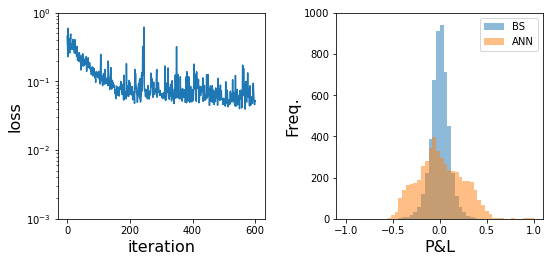

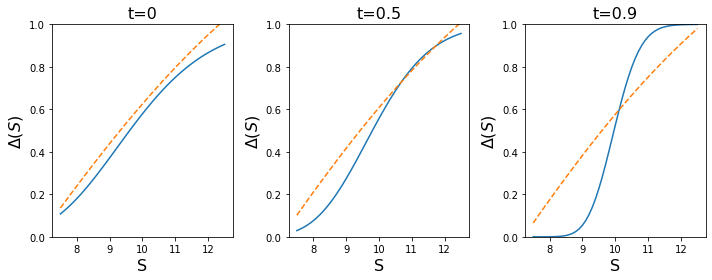

800


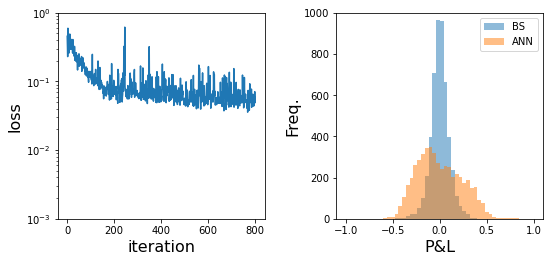

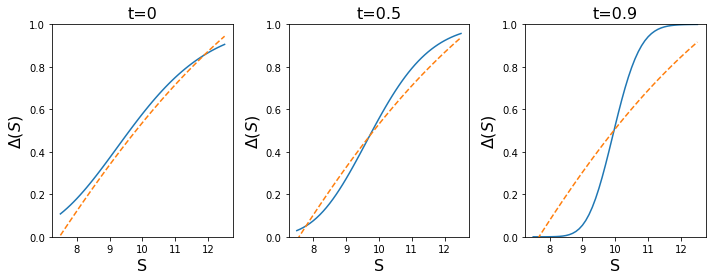

1000


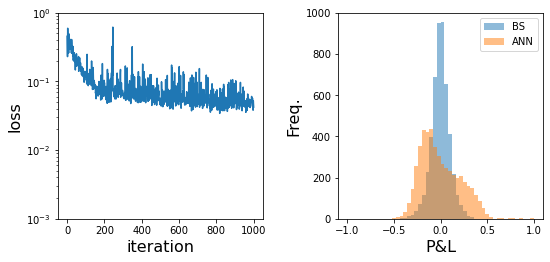

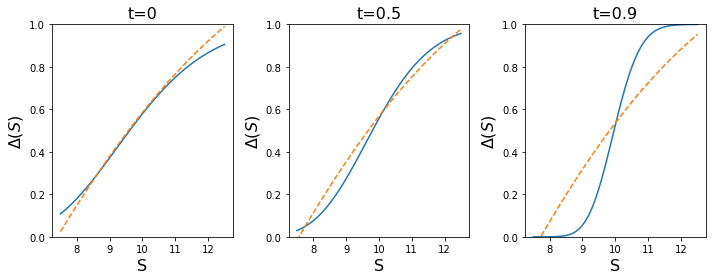

1200


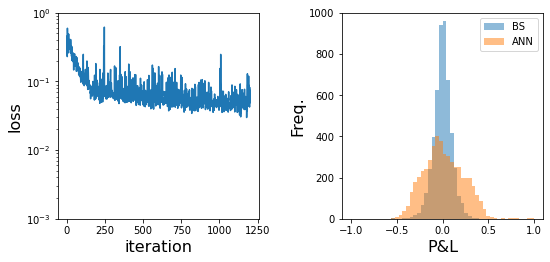

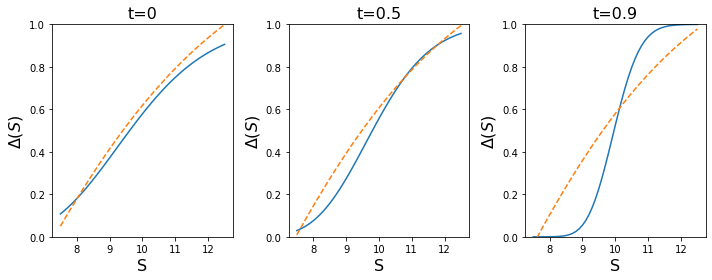

1400


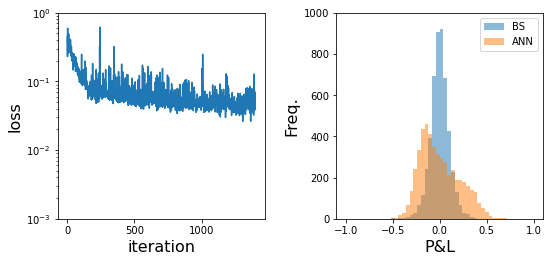

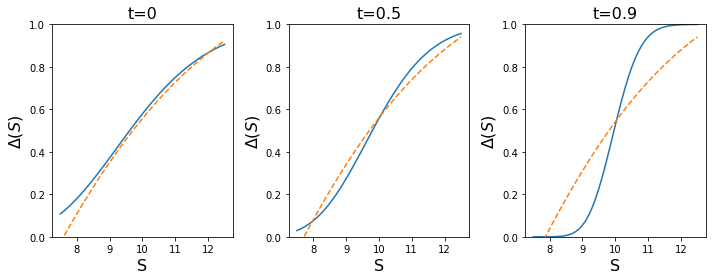

1600


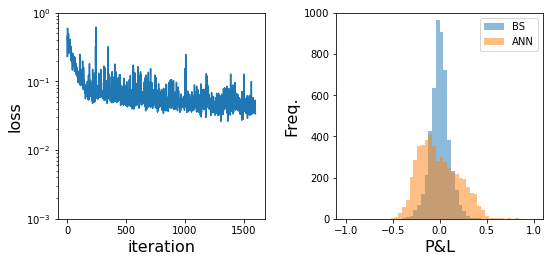

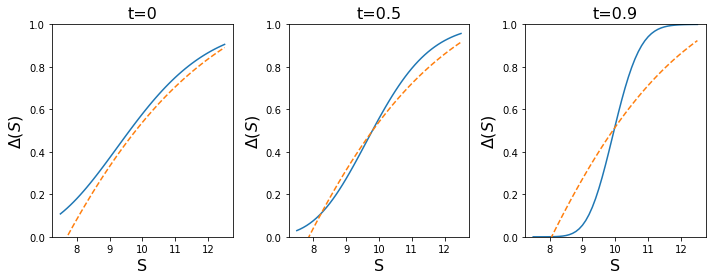

1800


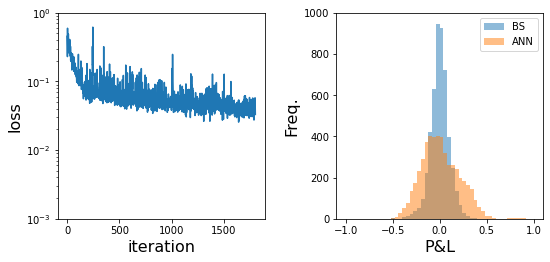

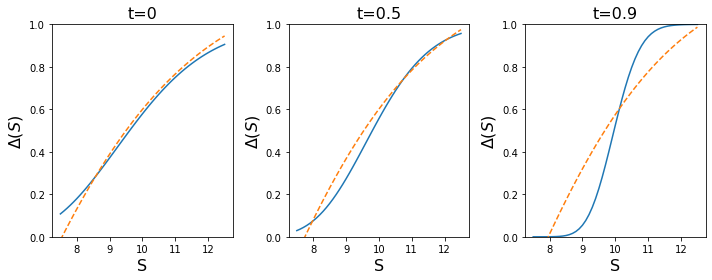

2000


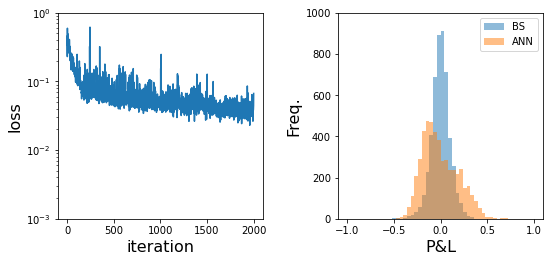

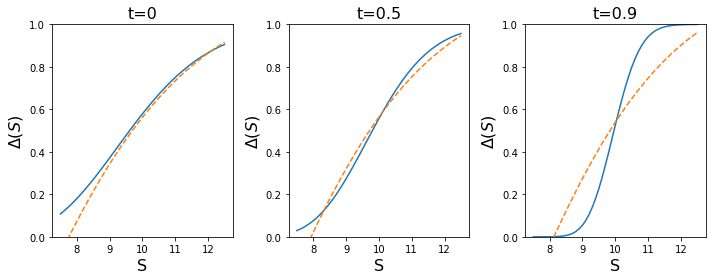

2200


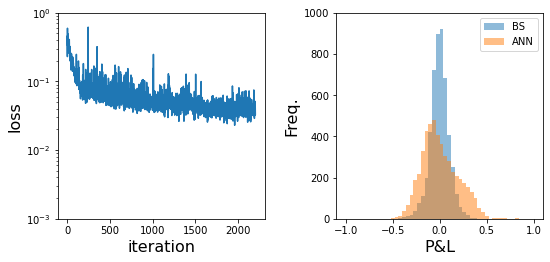

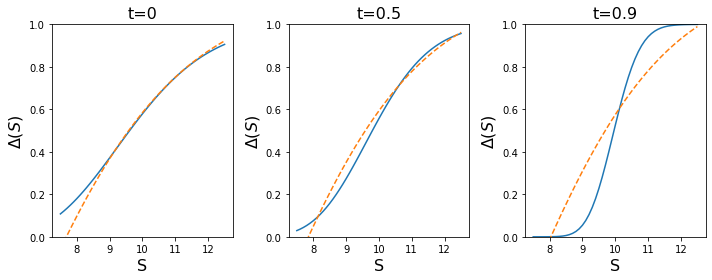

2400


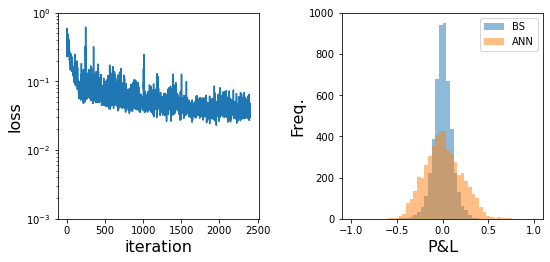

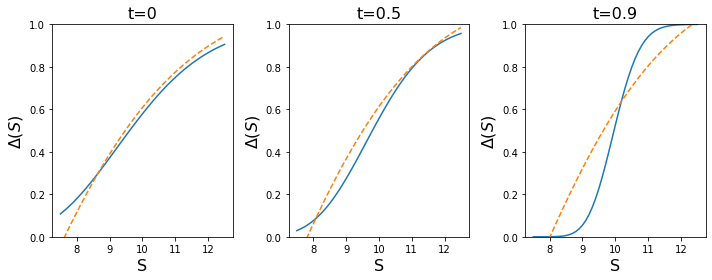

2600


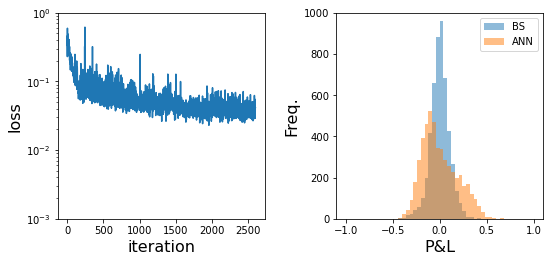

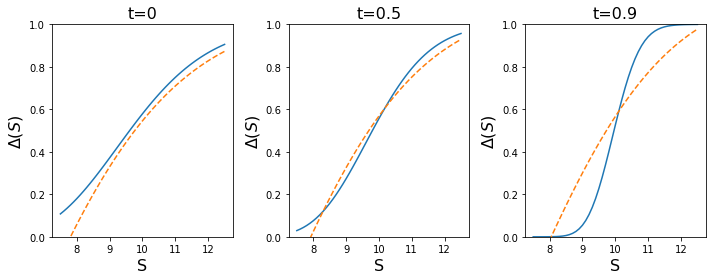

2800


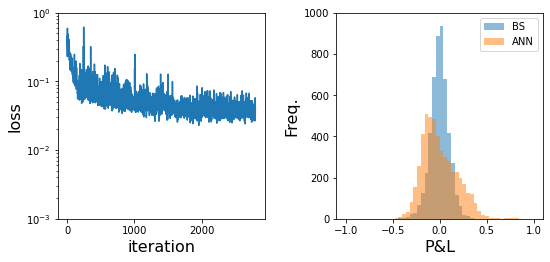

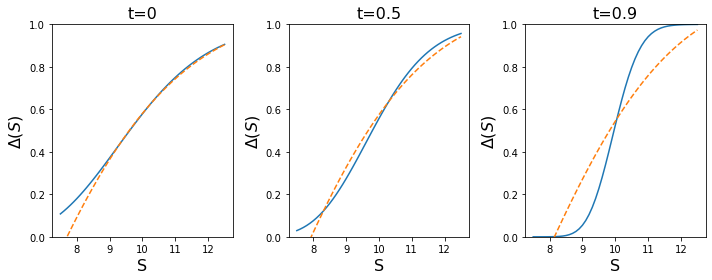

3000


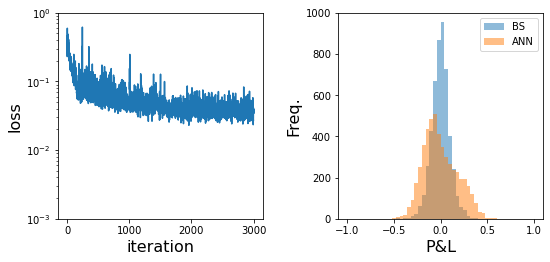

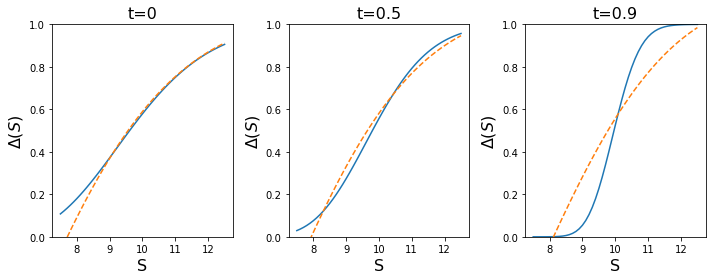

3200


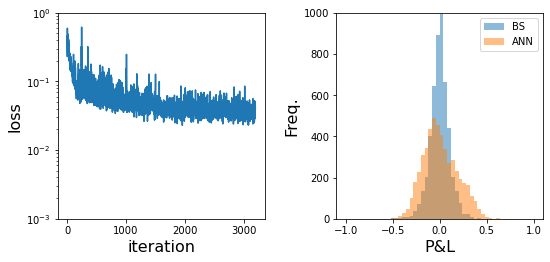

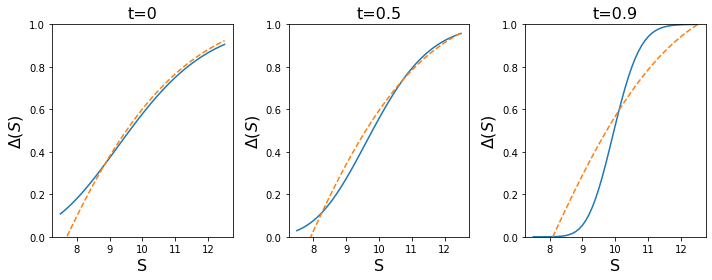

3400


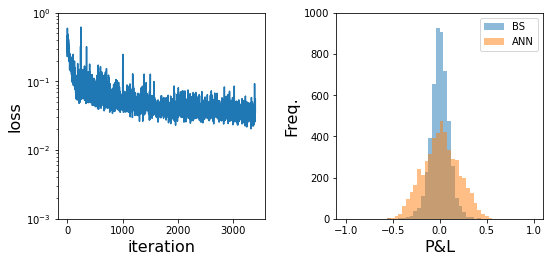

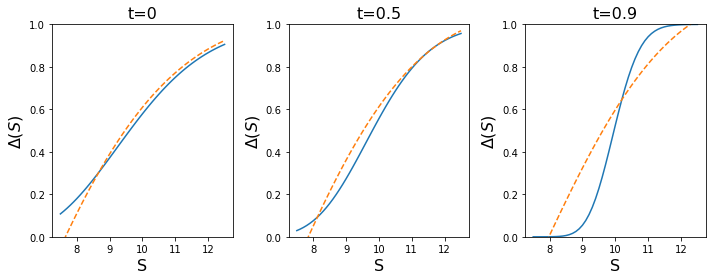

3600


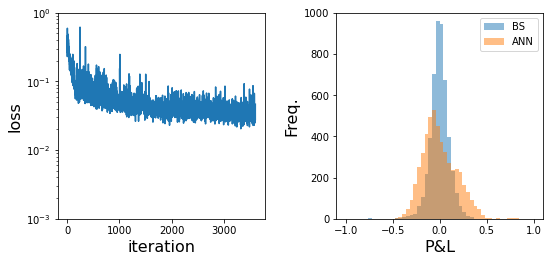

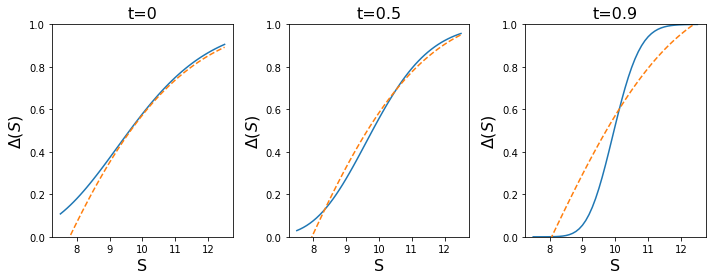

3800


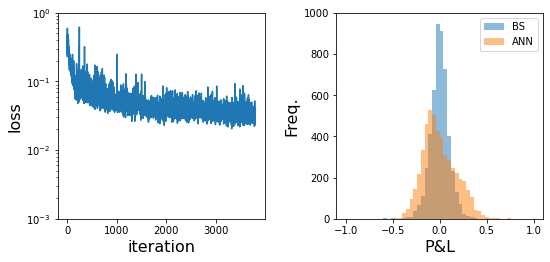

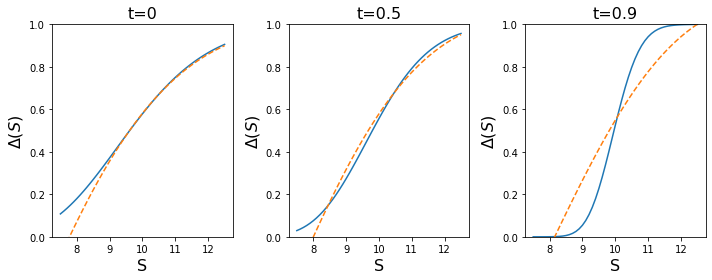

4000


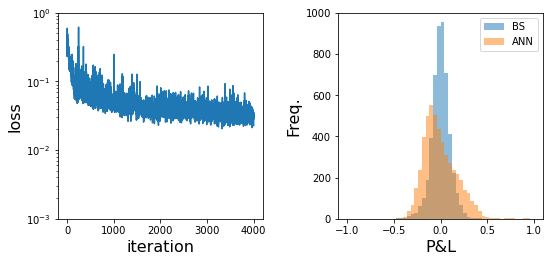

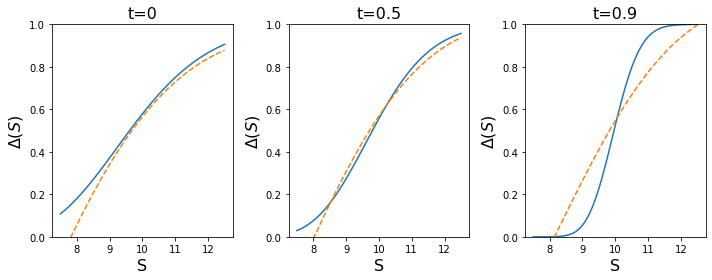

4200


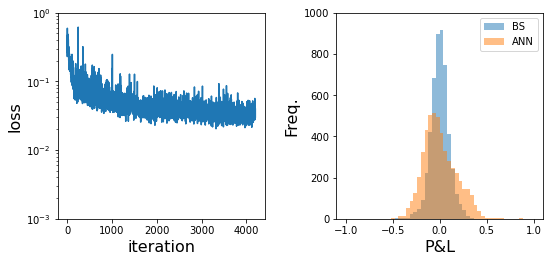

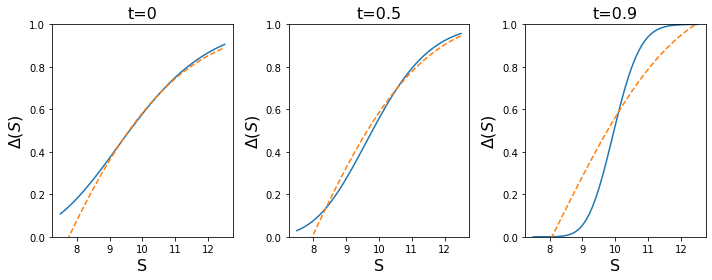

4400


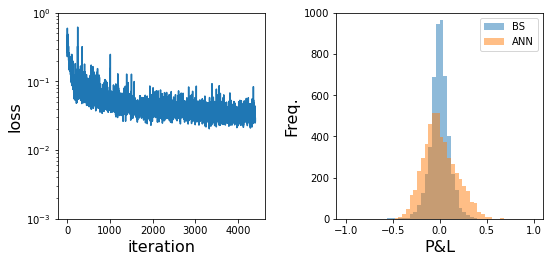

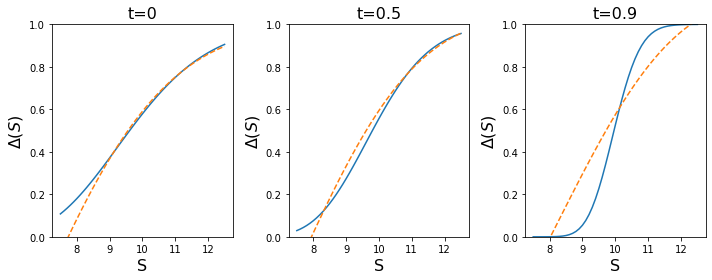

4600


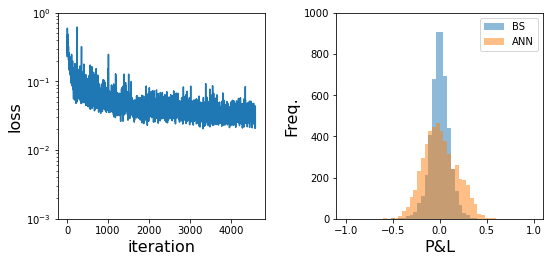

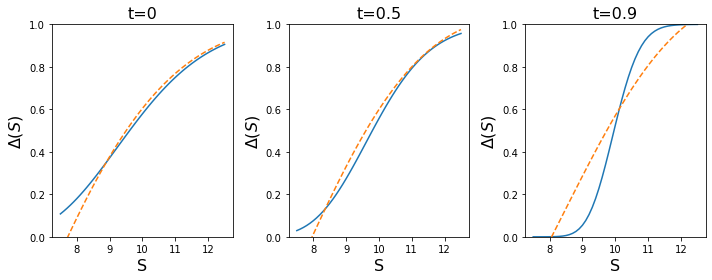

4800


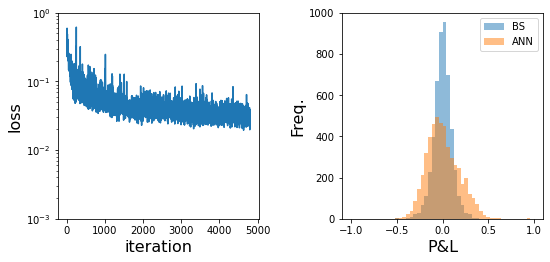

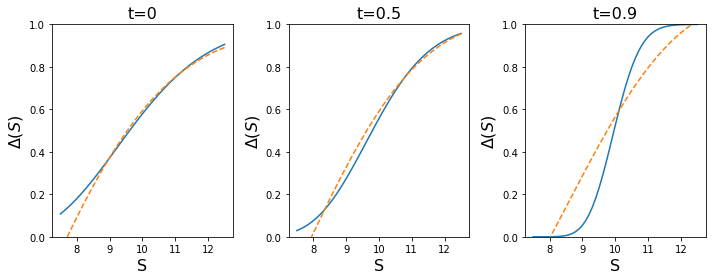

4999


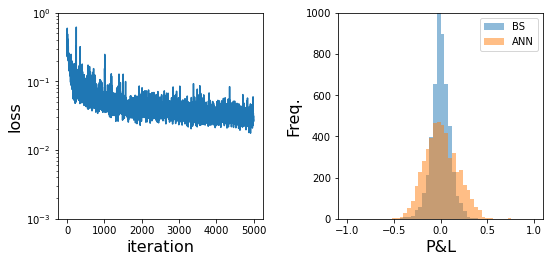

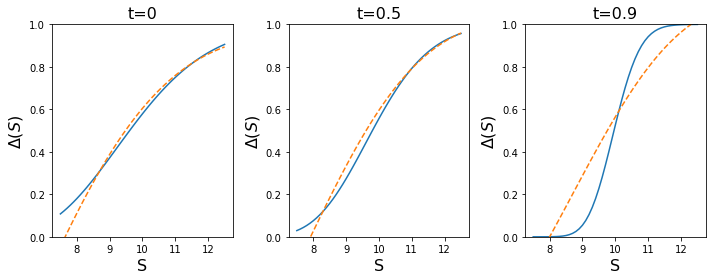

Finished Training


In [14]:
net = HedgeNet(50,1)
loss_hist = FitNet(net, "net_50_1")

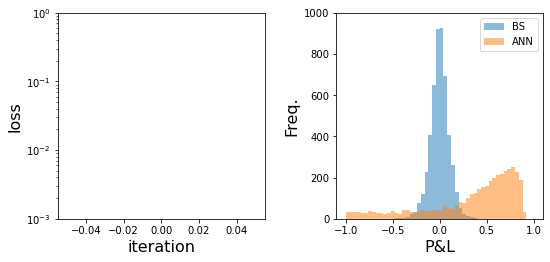

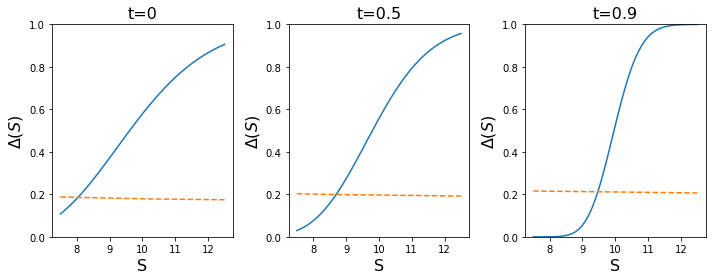

200


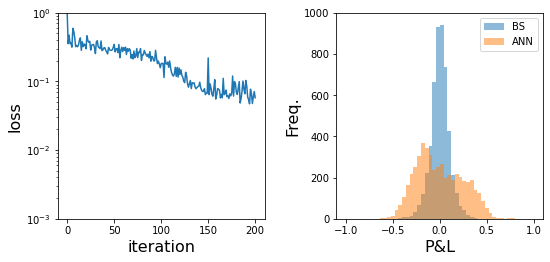

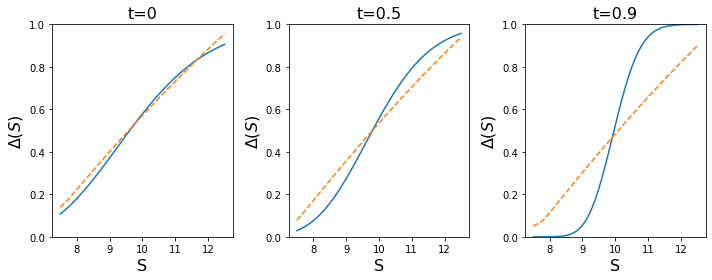

400


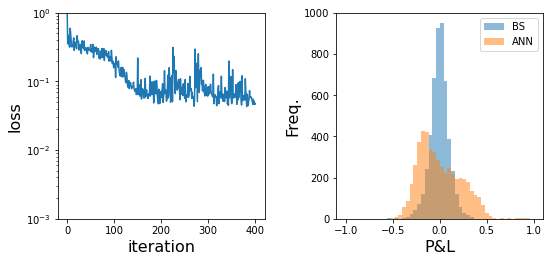

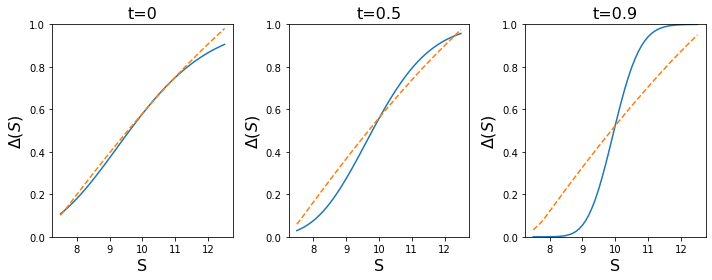

600


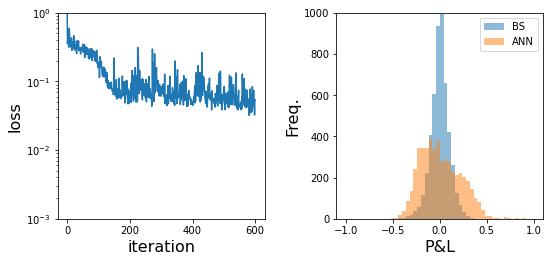

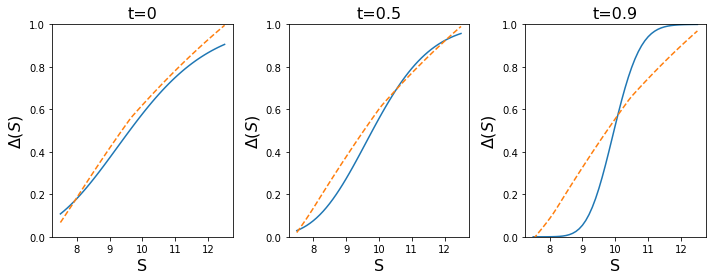

800


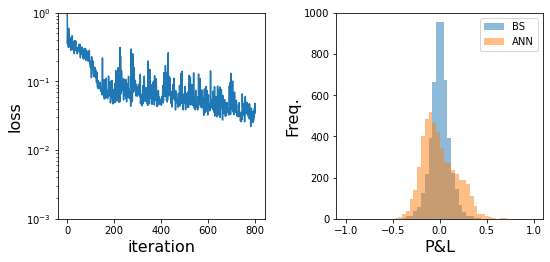

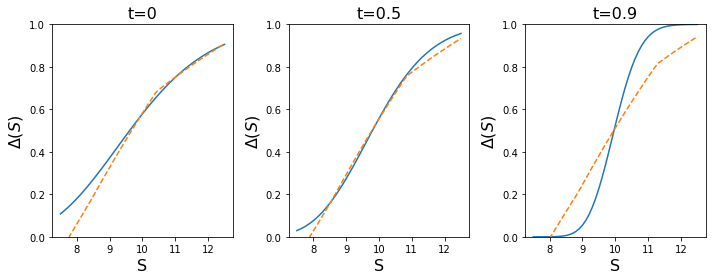

1000


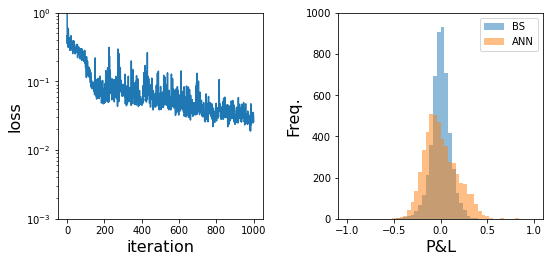

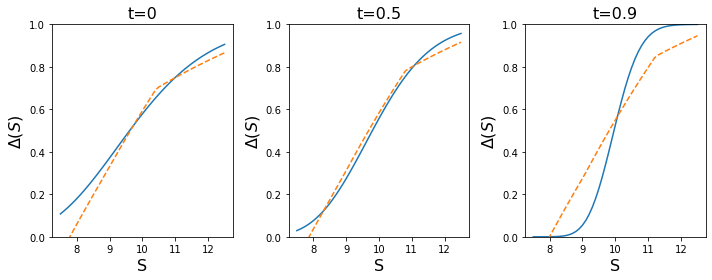

1200


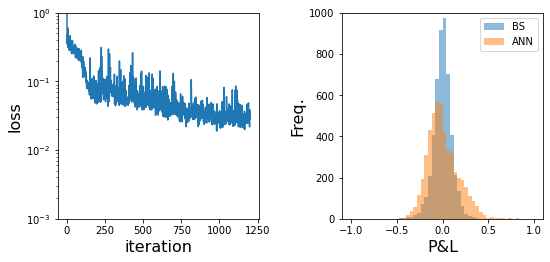

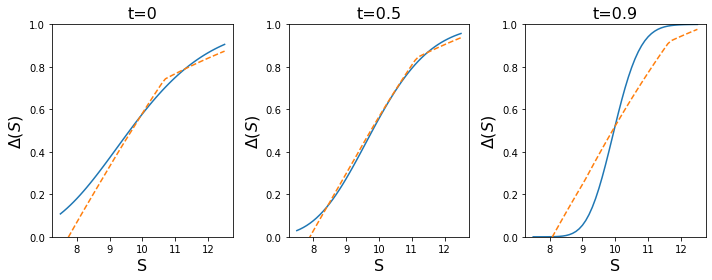

1400


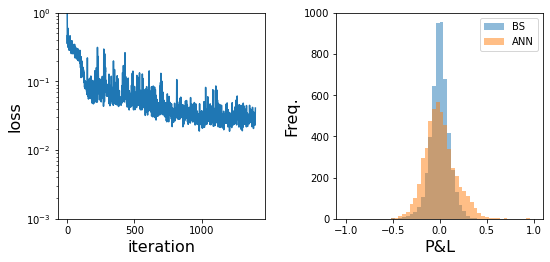

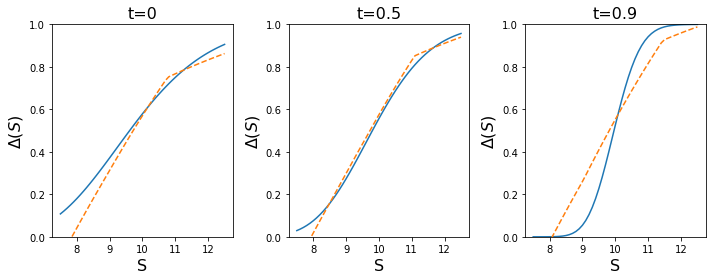

1600


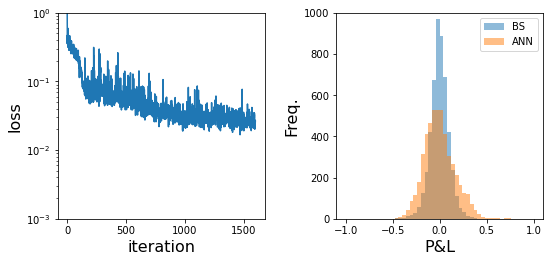

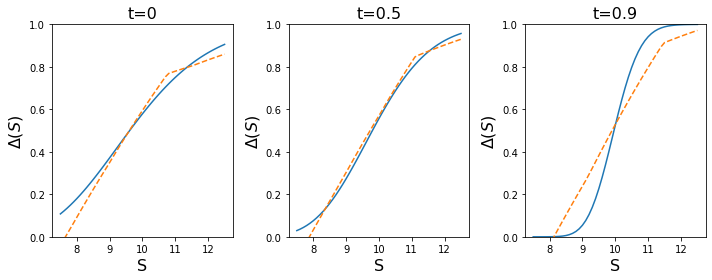

1800


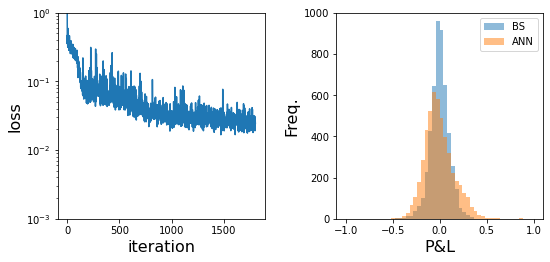

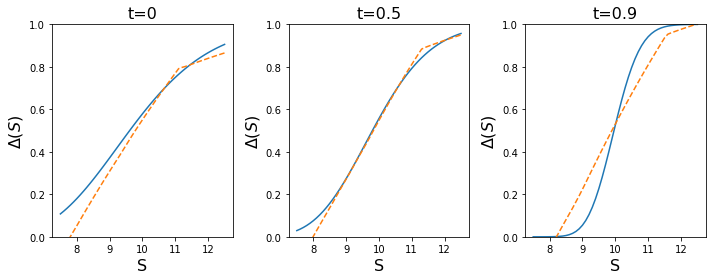

2000


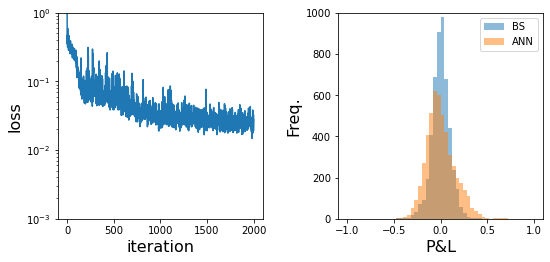

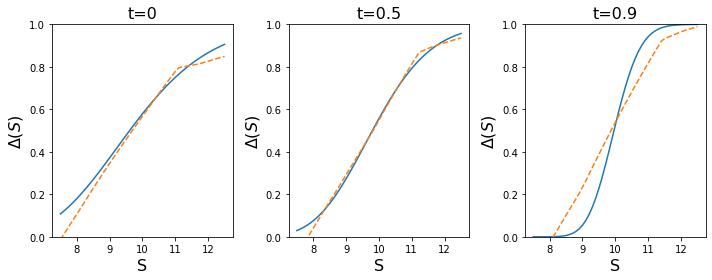

2200


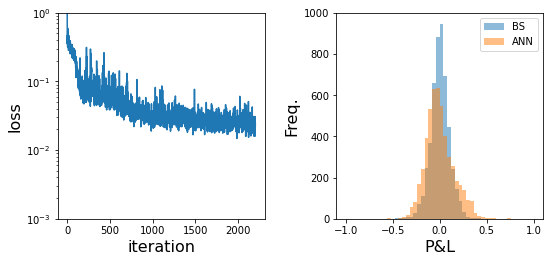

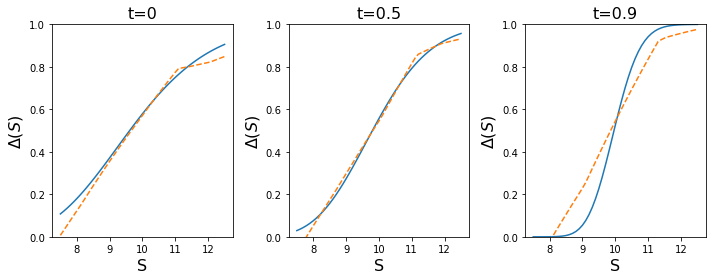

2400


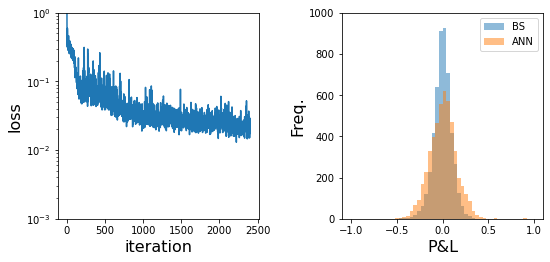

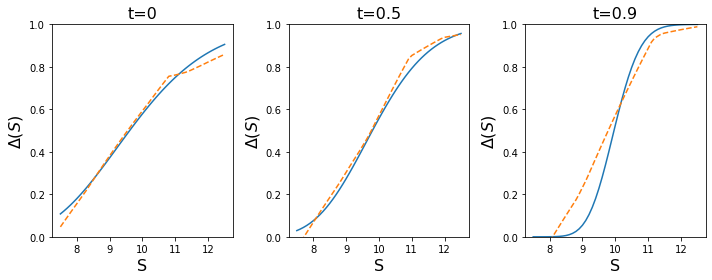

2600


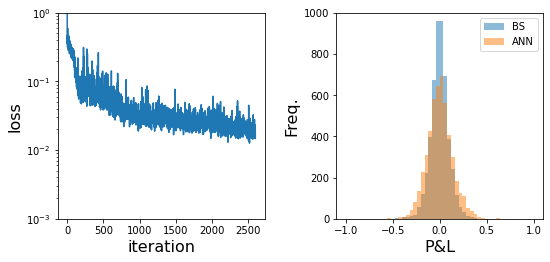

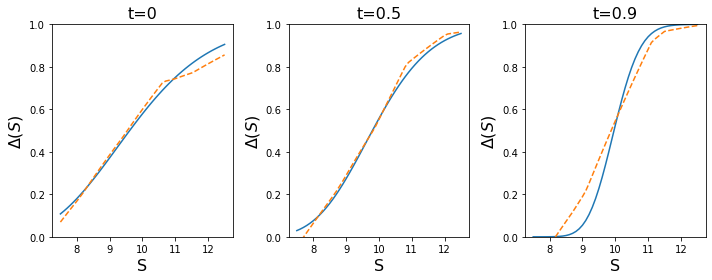

2800


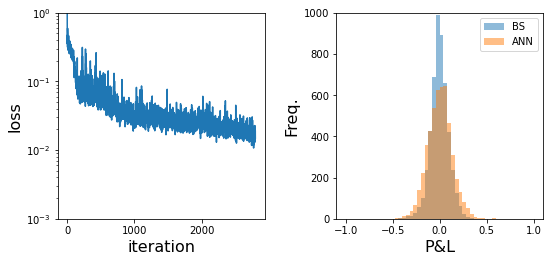

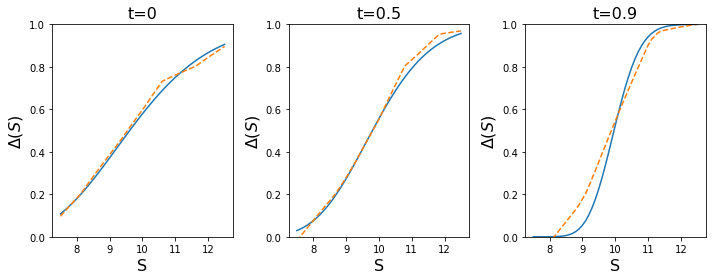

3000


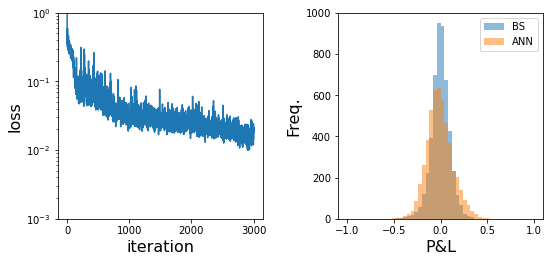

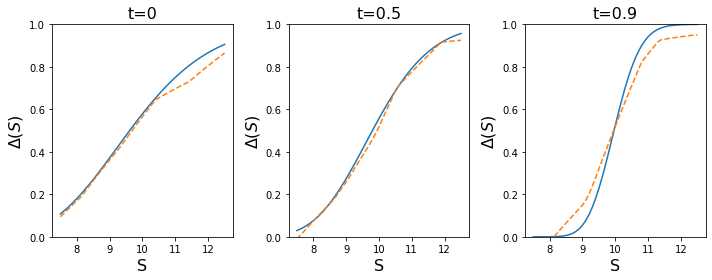

3200


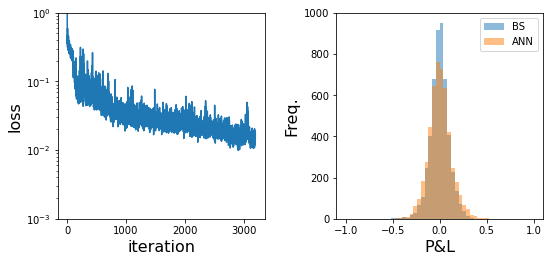

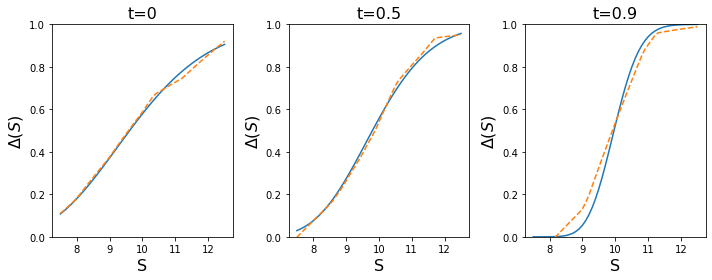

3400


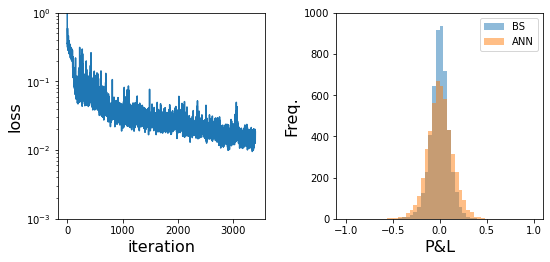

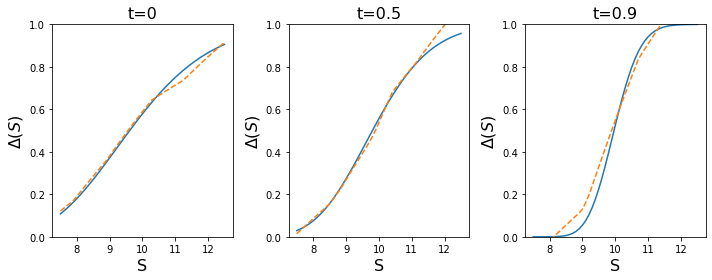

3600


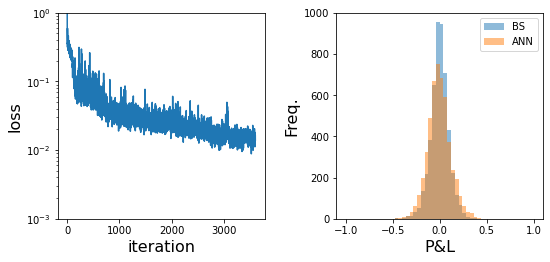

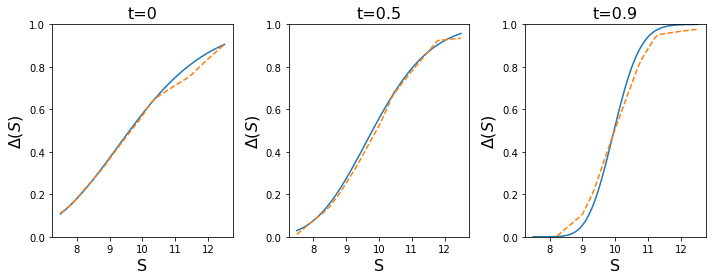

3800


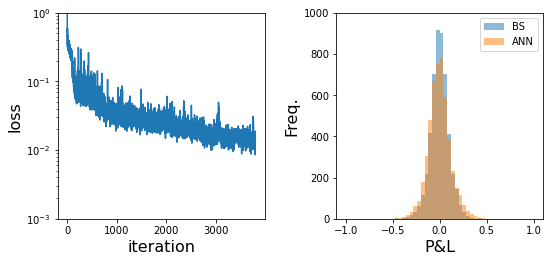

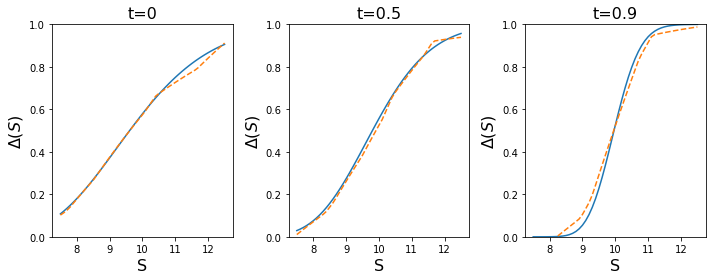

4000


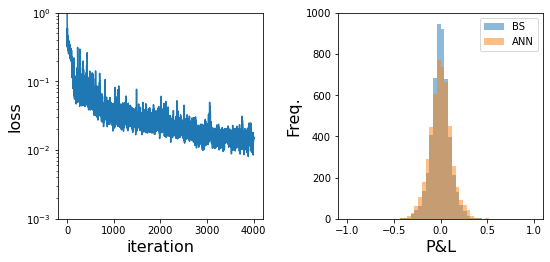

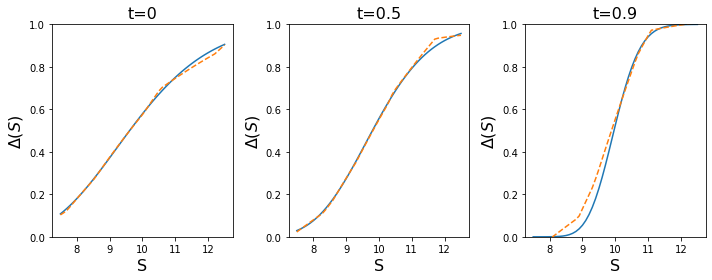

4200


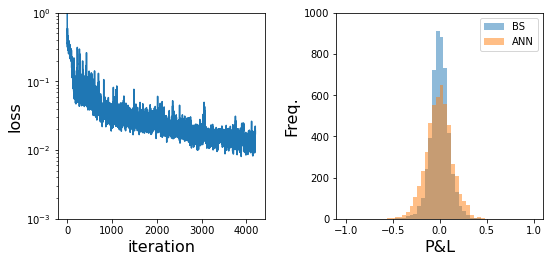

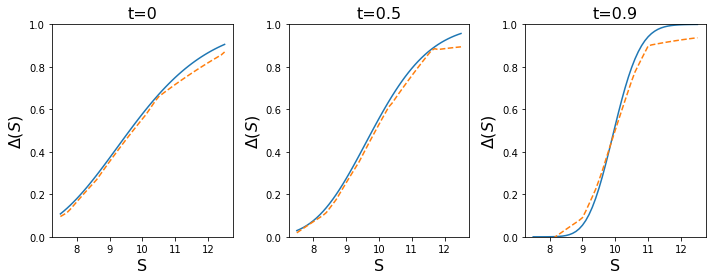

4400


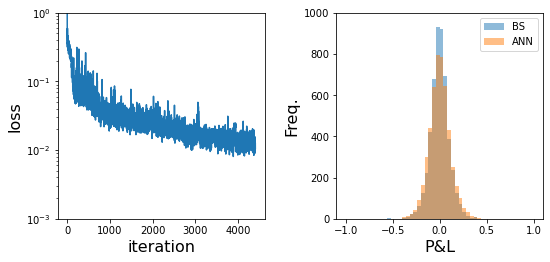

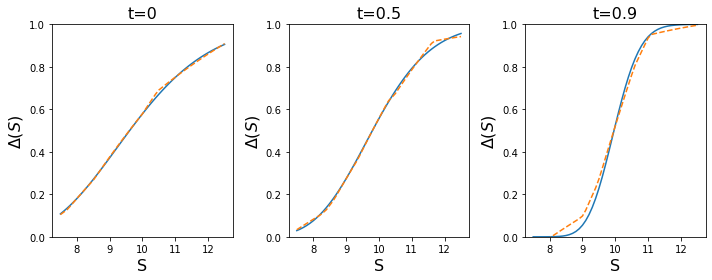

4600


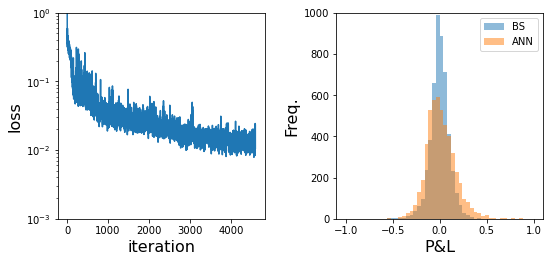

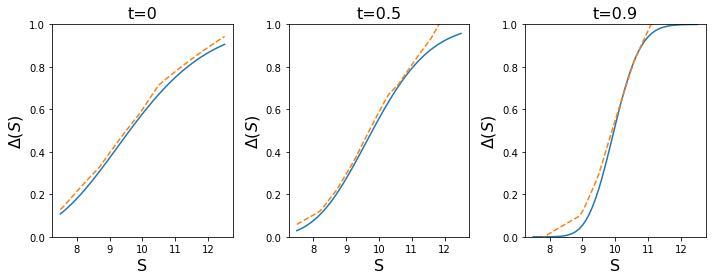

4800


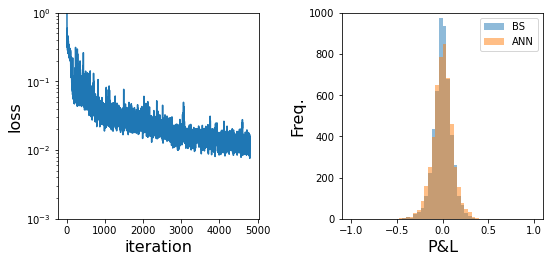

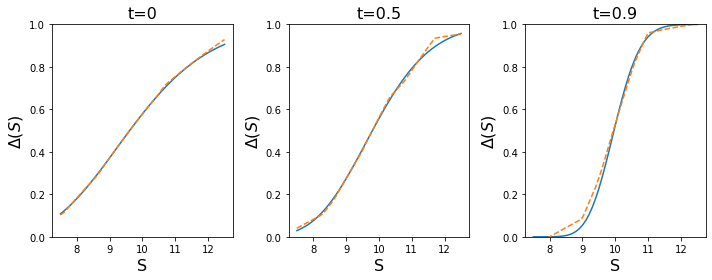

4999


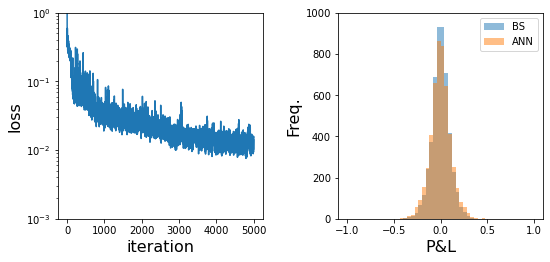

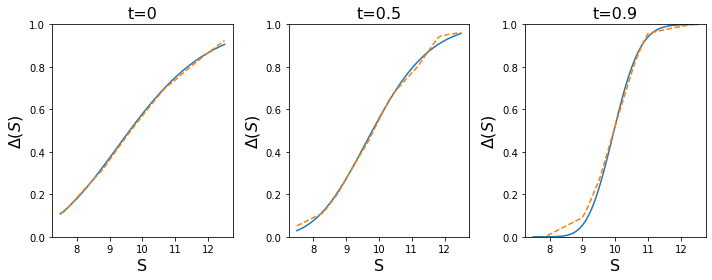

Finished Training


In [15]:
net = HedgeNet(25,2)
loss_hist = FitNet(net, "net_25_2")

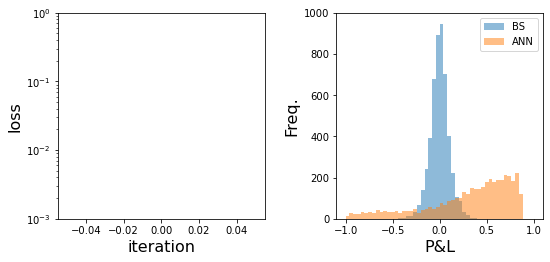

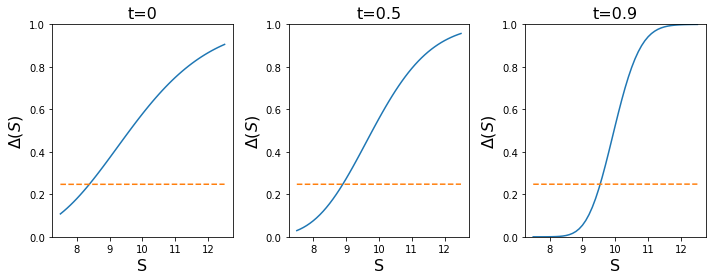

200


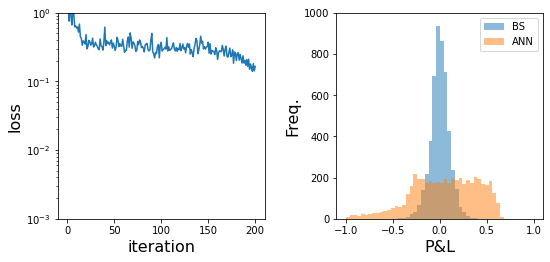

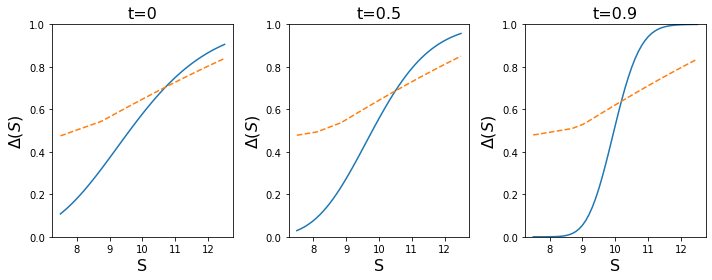

400


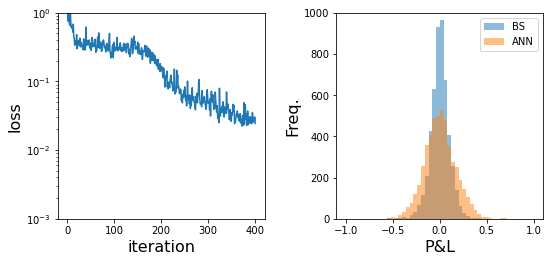

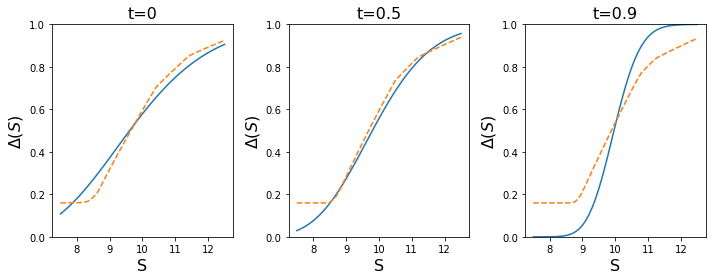

600


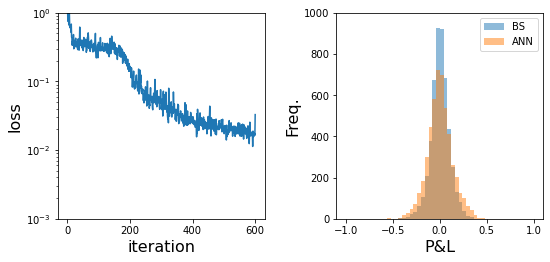

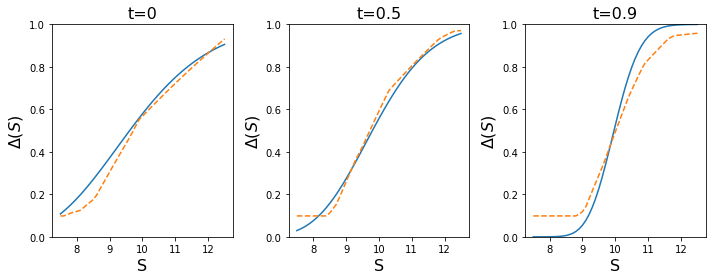

800


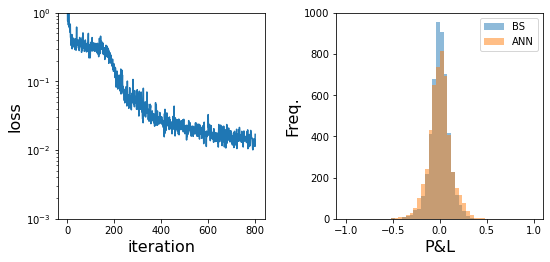

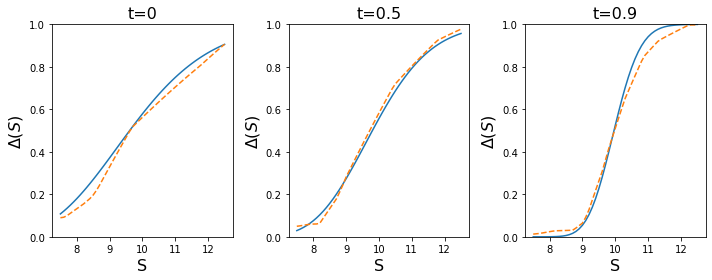

1000


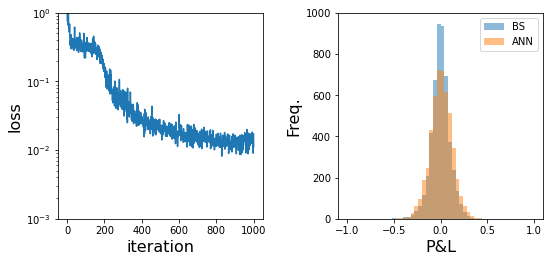

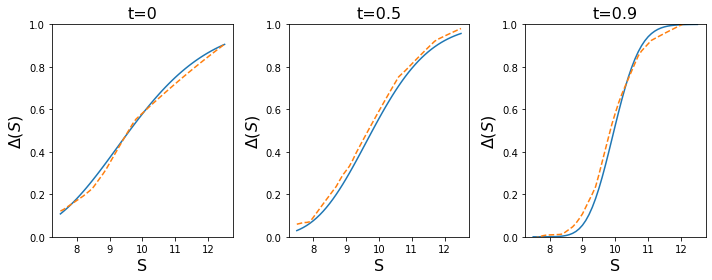

1200


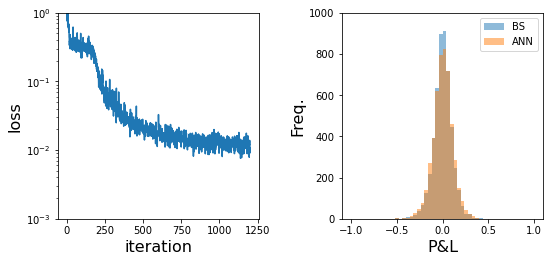

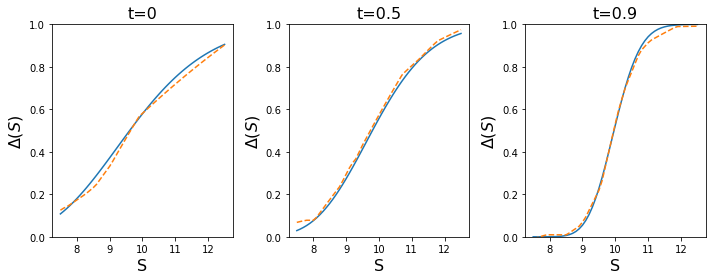

1400


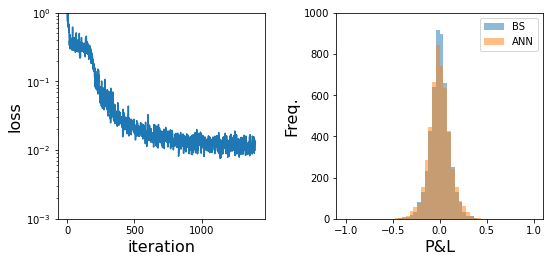

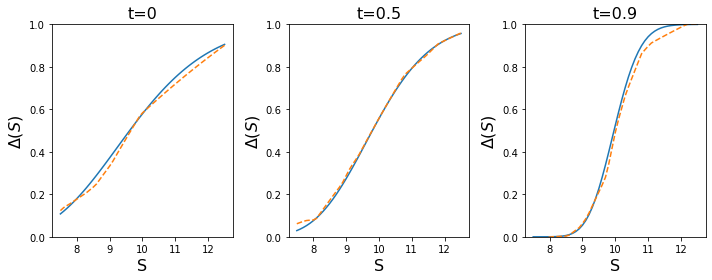

1600


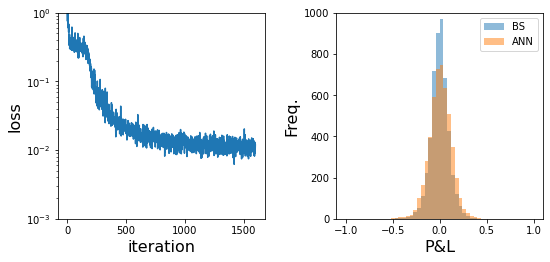

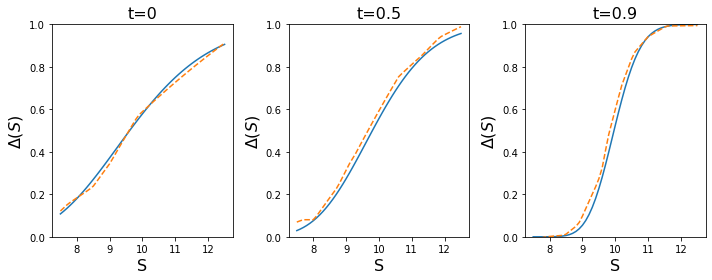

1800


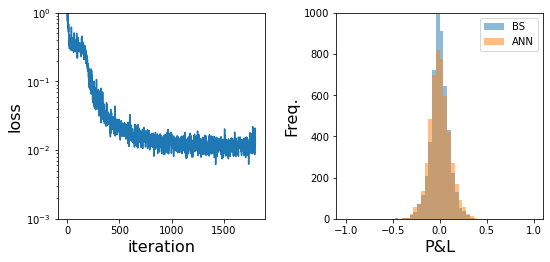

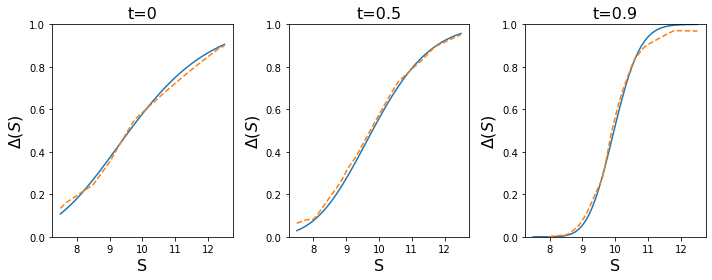

2000


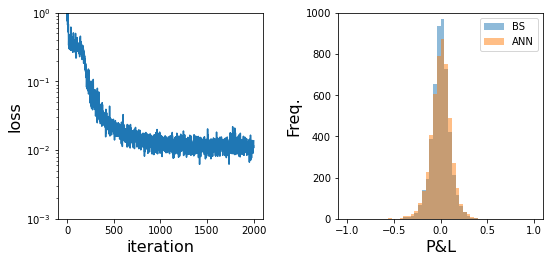

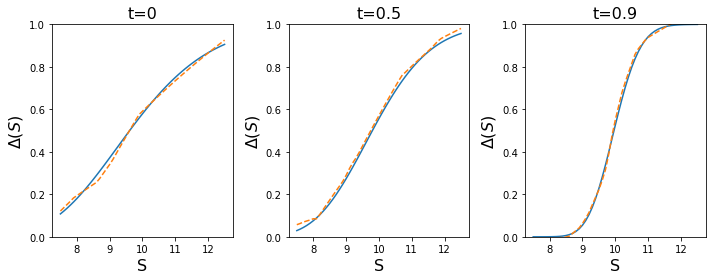

2200


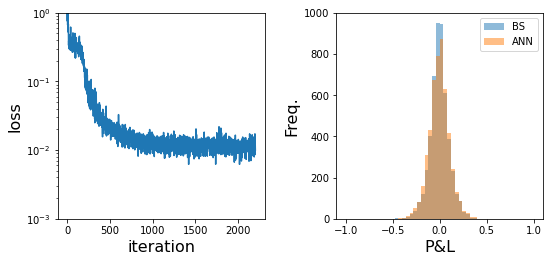

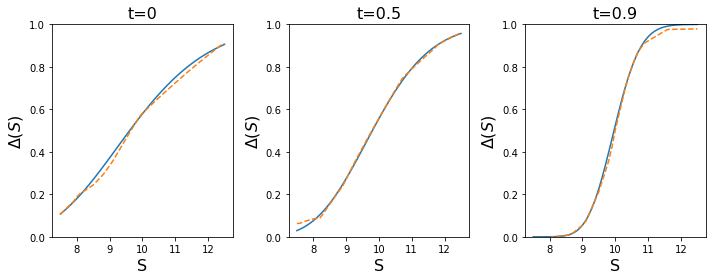

2400


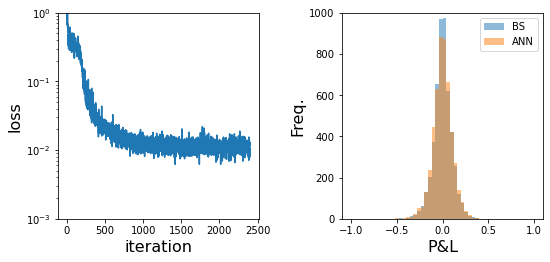

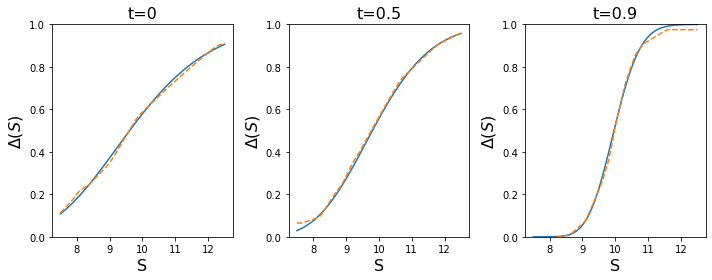

2600


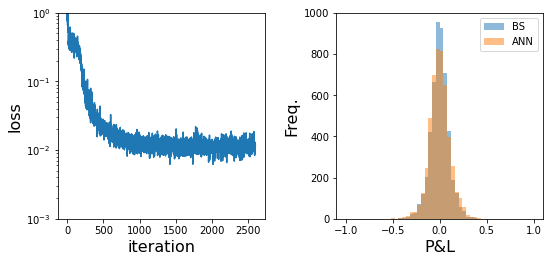

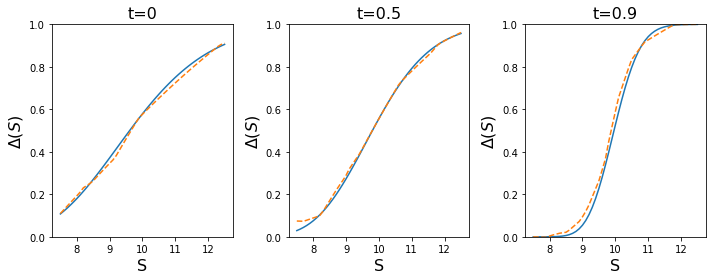

2800


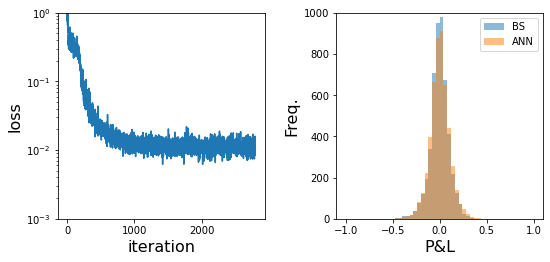

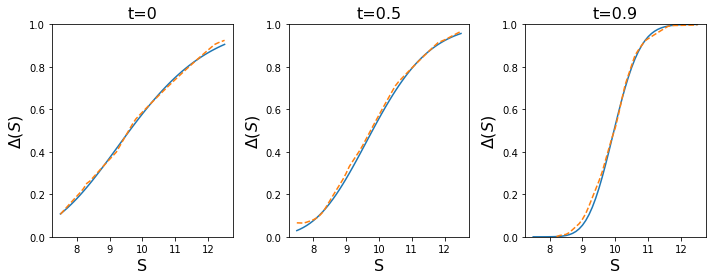

3000


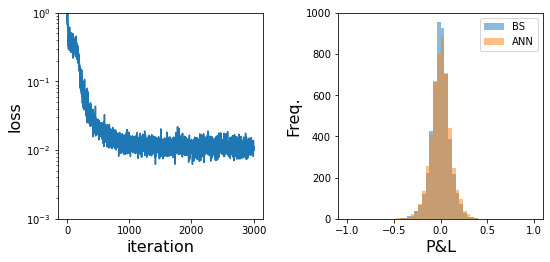

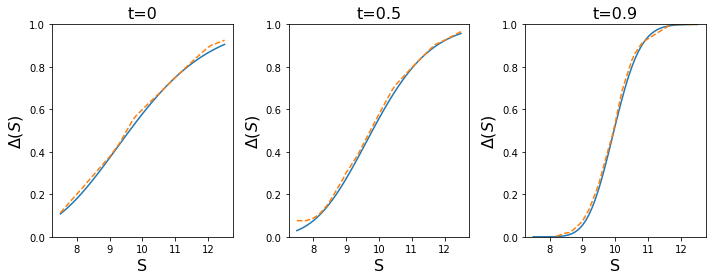

3200


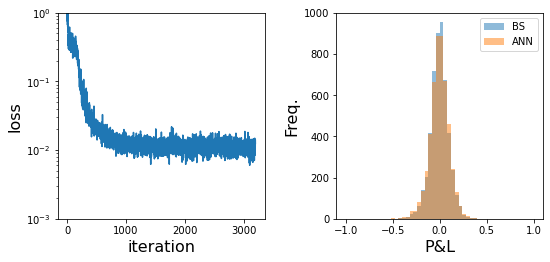

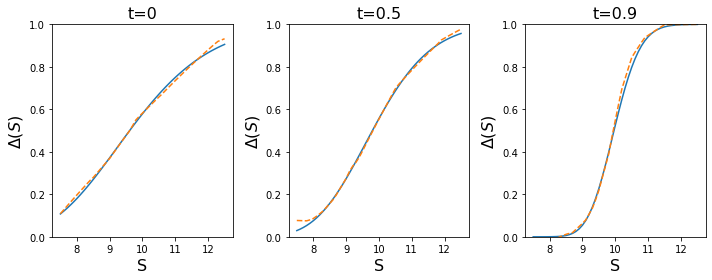

3400


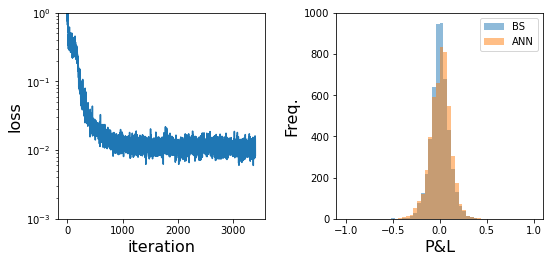

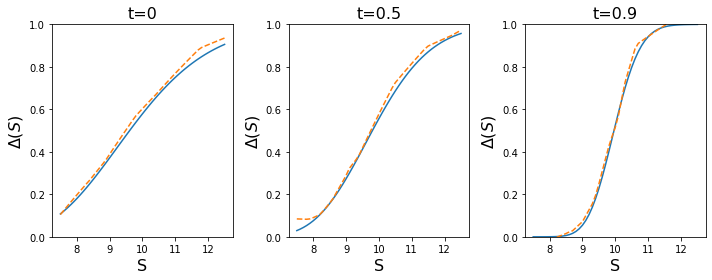

3600


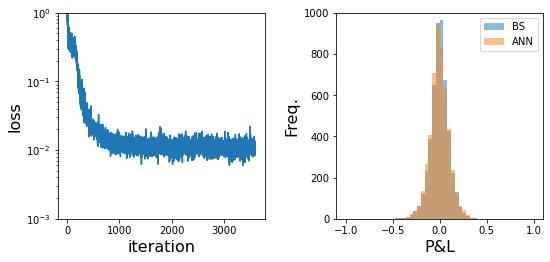

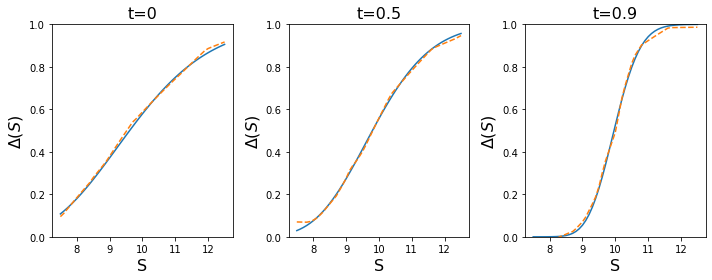

3800


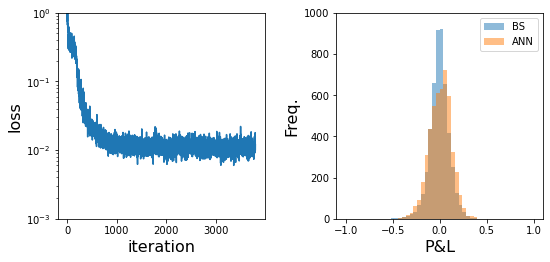

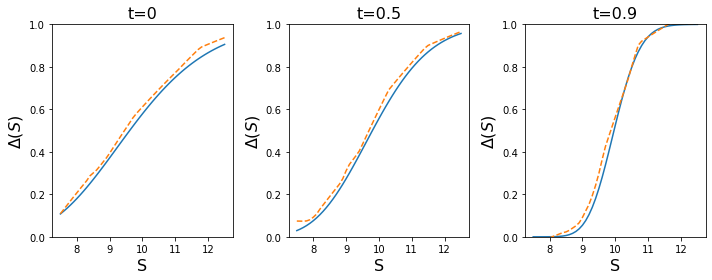

4000


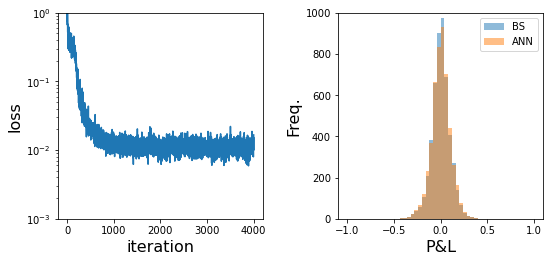

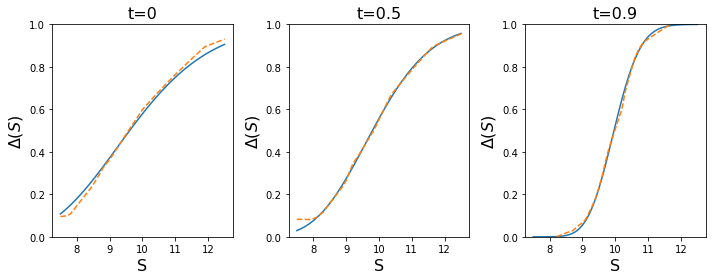

4200


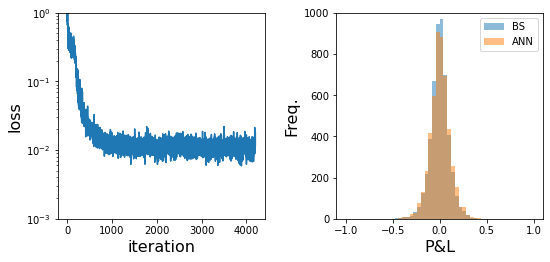

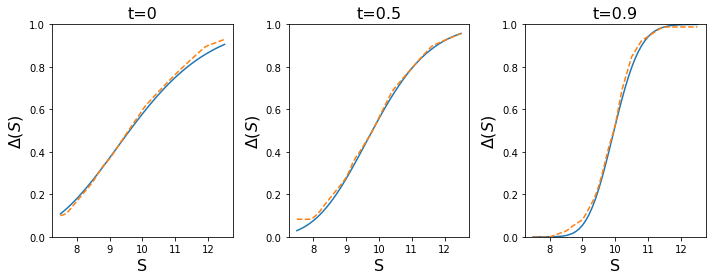

4400


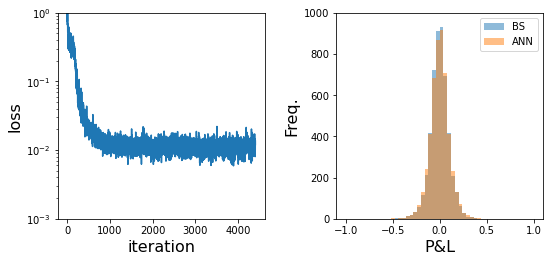

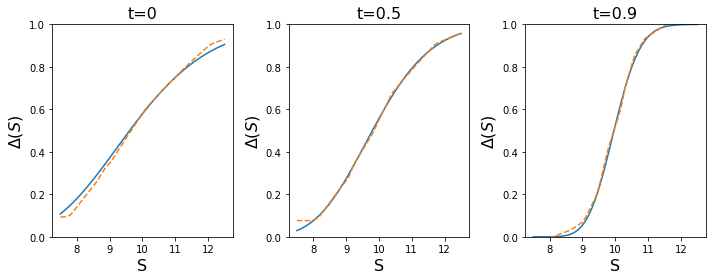

4600


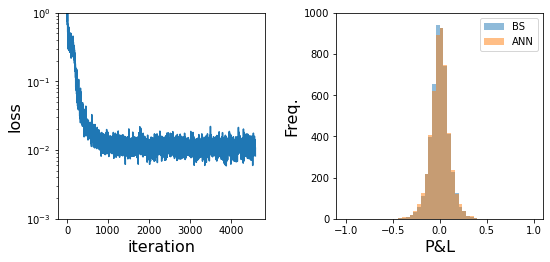

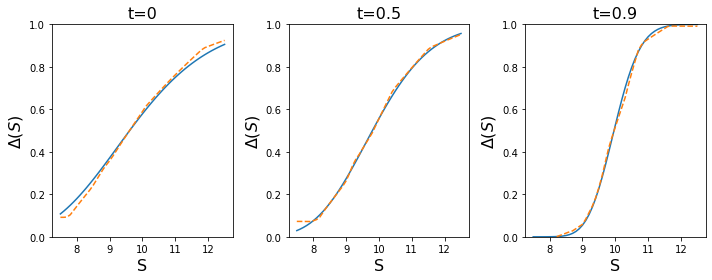

4800


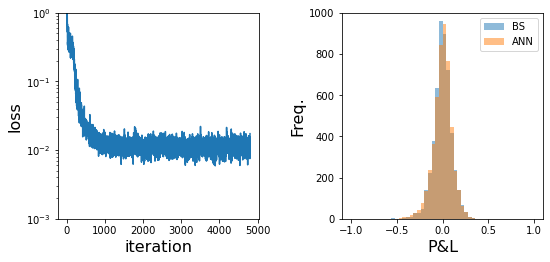

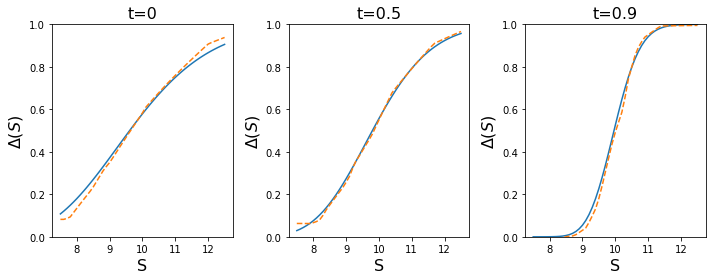

4999


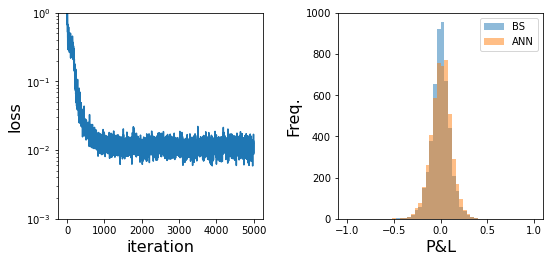

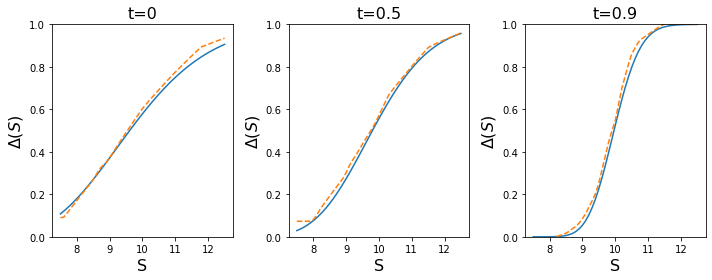

Finished Training


In [16]:
net = HedgeNet(10,5)
loss_hist = FitNet(net, "net_10_5")

In [27]:
# import os
# import moviepy.video.io.ImageSequenceClip
# image_folder='images'
# fps=4

# image_files = [os.path.join(image_folder,img)
#                for img in os.listdir(image_folder)
#                if img.endswith(".png")]
# clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
# clip.write_videofile('strat_50_1_dist.mp4')

t:   0%|                                                                              | 0/25 [00:00<?, ?it/s, now=None]

Moviepy - Building video strat_50_1_dist.mp4.
Moviepy - Writing video strat_50_1_dist.mp4



Moviepy - Done !
Moviepy - video ready strat_50_1_dist.mp4
